### Log Anomlay Detector Core Mininimal Implementation

In an effort to help new users and contributors understand the core Machine Learning elements of the log anomaly detector I have decided to recreate a streamlined minimal version. Here we will ignore any streaming or external aspect of our data and use a fixed local data file for simplicity and reproducability.   

This notebook will cover:
* Log Preprocessing
* Text Encoding
* Model Training
* Generating Anomlay Scores
* Model Inference /Prediction

For the most part function names have been made to match their relevent counter part in the larger code base.

My aim for this notebook is that, by the end a reader will 1) have a clear understanding of how the current implementation works and 2) know where to make changes to try another approach. 

### Import our packages

In [1]:
import os
import time
import numpy as np
import logging
import sompy



from multiprocessing import Pool
from itertools import product
import pandas as pd
import re
import gensim as gs
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
%matplotlib inline

CACHEDIR=/home/nadzya/.cache/matplotlib
Using fontManager instance from /home/nadzya/.cache/matplotlib/fontlist-v330.json
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
NumExpr defaulting to 4 threads.
Loaded backend module://matplotlib_inline.backend_inline version unknown.


### Define our Functions

#### 1. Log Preprocesing

One assumption that all these functions use is that we instantly convert our data into a pandas dataframe that has a "message" column containing the relevent information for us. 

We then treat each individual log line as a "word", cleaning it by removing all non-alphabet charcters including white spaces. 

In [2]:
def _preprocess(data):
    for col in data.columns:
        if col == "message":
            data[col] = data[col].apply(_clean_message)
        else:
            data[col] = data[col].apply(to_str)

    data = data.fillna("EMPTY")
    
def _clean_message(line):
    """Remove all none alphabetical characters from message strings."""
    return "".join(
        re.findall("[a-zA-Z]+", line)
    )  # Leaving only a-z in there as numbers add to anomalousness quite a bit

def to_str(x):
    """Convert all non-str lists to string lists for Word2Vec."""
    ret = " ".join([str(y) for y in x]) if isinstance(x, list) else str(x)
    return ret

#### 2. Text Encoding  

Here we employ the gensim implementation of Word2Vec to encode our logs as fixed length numerical vectors. Logs are noteably not the natural usecase for word2vec, but this appraoch attemps to leverage the fact that logs lines themselves, like words, have a context, so encoding a log based on its co-occurence with other logs does make some intuitive sense.

In [3]:
def create(words, vector_length, window_size):
    """Create new word2vec model."""
    w2vmodel = {}
    for col in words.columns:
        if col in words:
            w2vmodel[col] = gs.models.Word2Vec([list(words[col])], min_count=1, size=vector_length, 
                                     window=window_size, seed=42, workers=1, iter=550,sg=0)
        else:
            #_LOGGER.warning("Skipping key %s as it does not exist in 'words'" % col)
            pass
        
    return w2vmodel

def one_vector(new_D, w2vmodel):
    """Create a single vector from model."""
    transforms = {}
    for col in w2vmodel.keys():
        if col in new_D:
            transforms[col] = w2vmodel[col].wv[new_D[col]]

    new_data = []

    for i in range(len(transforms["message"])):
        logc = np.array(0)
        for _, c in transforms.items():
            if c.item(i):
                logc = np.append(logc, c[i])
            else:
                logc = np.append(logc, [0, 0, 0, 0, 0])
        new_data.append(logc)

    return np.array(new_data, ndmin=2)


#### 3. Model Training

Here we employ the SOMPY implementation of the Self-Organizing Map to train our model. This function simply makes it a bit easier for the user to interact with the sompy training requirements. This function returns a trained model.

The trained model object also has a method called codebook.matrix() which allows the user access directly to the trained self organizing map itself. If the map successfull converged then it should consist of nodes in our N-dimensional log space that are well ordered and provide an approximation to the topology of the logs in our training set.

During training we also, compute the distances of our training data to the trained map as a baseline to build a threashold.   

In [4]:
def train(inp, map_size, iterations, parallelism):
    print('training dataset is of size {inp.shape[0]}')
    mapsize = [map_size, map_size]
    np.random.seed(42)
    som = sompy.SOMFactory.build(inp, mapsize , initialization='random')
    som.train(n_job=parallelism, train_rough_len=100,train_finetune_len=5)
    model = som.codebook.matrix.reshape([map_size, map_size, inp.shape[1]])
    
    #distances = get_anomaly_score(inp, 8, model)
    #threshold = 3*np.std(distances) + np.mean(distances)
    
    return som #,threshold

#### 4. Generating Anomaly Scores

One of the key elements of this approach is quantifying the distance between our logs and the nodes on our self organizing map. The two functions below, taken together, represent a parrallel implementation for performing this calculaton.  

In [5]:
def get_anomaly_score(logs, parallelism, model): # for whole dataset 

    parameters = [[x,model] for x in logs]
    pool = Pool(parallelism)
    dist = pool.map(calculate_anomaly_score, parameters) 
    pool.close()
    pool.join()
    #dist = [] 
    #for log in logs:
    #    dist.append(calculate_anomaly_score(log,model))
    
    return dist

def calculate_anomaly_score(parameters): # for a data point 
    log = parameters[0]
    model = parameters[1]
    """Compute a distance of a log entry to elements of SOM."""
    dist_smallest = np.inf
    for x in range(model.shape[0]):
        for y in range(model.shape[1]):
            dist = cosine(model[x][y],log) 
            #dist = np.linalg.norm(model[x][y] - log)
            if dist < dist_smallest:
                dist_smallest = dist
    return dist_smallest


#### 5. Model Inference / Prediction

Here we are making an inference about a new log message. This is done by scoring the incoming log and evaluating whether or not it passess a certain threshold value.  


Ideally our word2vec has been monitoring our application long enough to have seen all the logs. So, if we get a known log we can simply look up its vector representation   

One downside with word2vec is that its quite brittle when it comes to incorporating words that haven't been seen before. In this example, we will retrain the W2Vmodel if our new log has not been seen by the before.  

In [6]:
def infer(w2v, som, log, data, threshold):
    
    log =  pd.DataFrame({"message":log},index=[1])
    _preprocess(log)
    
    if log.message.iloc[0] in list(w2v['message'].wv.vocab.keys()):
        vector = w2v["message"].wv[log.message.iloc[0]]
    else:
        w2v = gs.models.Word2Vec([[log.message.iloc[0]] + list(data["message"])], 
                                 min_count=1, size=100, window=3, seed=42, workers=1, iter=550, sg=0)
        vector = w2v.wv[log.message.iloc[0]]
    
    score = get_anomaly_score([vector], 1, som)
    
    if score < threshold:
        return 0, score
    else:
        return 1, score


### Implementation

First we read in our test dataset and preprocesses. Here was can see this is a rather small example, with 10,000 log lines, but only 3 unique log messages

In [12]:
data_path = "/home/nadzya/Apps/log-anomaly-detector/validation_data//log_anomaly_detector-10000-events.json"

In [13]:
data = pd.read_json(data_path)

In [14]:
_preprocess(data)
data.head()

,message
0,DEBUGProcessedoutofpackages
1,DEBUGProcessedoutofpackages
2,DEBUGProcessedoutofpackages
3,DEBUGProcessedoutofpackages
4,DEBUGProcessedoutofpackages


In [15]:
data.tail()

,message
9995,DEBUGProcessedoutofpackages
9996,DEBUGProcessedoutofpackages
9997,DEBUGProcessedoutofpackages
9998,DEBUGProcessedoutofpackages
9999,DEBUGProcessedoutofpackages


In [16]:
x = data.message.value_counts()
for i in x.keys():
    print(i, x[i])

DEBUGProcessedoutofpackages 9786
ThreadodcsserverINFOComposetypestatedoneComposedone 213
rootCMDusrlocalbinmonitorapachestatsshdevnull 1


#### Encode our logs

We then create our w2vmodel based on our preprocessed dataset and replace our log lines with thier vectorized representation. 

In [17]:
w2vmodel = create(data, 100,3)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 3 word types from a corpus of 10000 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 3 unique words (100% of original 3, drops 0)
effective_min_count=1 leaves 10000 word corpus (100% of original 10000, drops 0)
deleting the raw counts dictionary of 3 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 379 word corpus (3.8% of prior 10000)
estimated required memory for 3 words and 100 dimensions: 3900 bytes
resetting layer weights
training model with 1 workers on 3 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10000 raw words (377 effective words) took 0.0s, 107674 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 35 : training on 10000 raw words (366 effective words) took 0.0s, 53685 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 36 : training on 10000 raw words (354 effective words) took 0.0s, 107307 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 37 : training on 10000 raw words (381 effective words) took 0.0s, 87357 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 38 : training on 10000 raw words (378 effective words) took 0.0s, 81841 effective words/s
job loop exiting, total 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 39 : training on 10000

worker exiting, processed 1 jobs
EPOCH - 72 : training on 10000 raw words (376 effective words) took 0.0s, 90992 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 73 : training on 10000 raw words (395 effective words) took 0.0s, 63105 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 74 : training on 10000 raw words (349 effective words) took 0.0s, 86838 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 75 : training on 10000 raw words (381 effective words) took 0.0s, 23214 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 76 : training on 10000 raw words (366 effective words) took 0.0s, 59869 effecti

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 110 : training on 10000 raw words (403 effective words) took 0.0s, 36671 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 111 : training on 10000 raw words (384 effective words) took 0.0s, 66946 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 112 : training on 10000 raw words (365 effective words) took 0.0s, 58874 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 113 : training on 10000 raw words (400 effective words) took 0.0s, 56930 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more th

worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 147 : training on 10000 raw words (401 effective words) took 0.0s, 57792 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 148 : training on 10000 raw words (364 effective words) took 0.0s, 46037 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 149 : training on 10000 raw words (361 effective words) took 0.0s, 84959 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 150 : training on 10000 raw words (400 effective words) took 0.0s, 74753 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 151 : training on

worker thread finished; awaiting finish of 0 more threads
EPOCH - 184 : training on 10000 raw words (378 effective words) took 0.0s, 44141 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 185 : training on 10000 raw words (383 effective words) took 0.0s, 97093 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 186 : training on 10000 raw words (416 effective words) took 0.0s, 52857 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 187 : training on 10000 raw words (373 effective words) took 0.0s, 83599 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 188 : training on 10000 raw words (391 effective w

EPOCH - 221 : training on 10000 raw words (394 effective words) took 0.0s, 61490 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 222 : training on 10000 raw words (386 effective words) took 0.0s, 51359 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 223 : training on 10000 raw words (407 effective words) took 0.0s, 102941 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 224 : training on 10000 raw words (355 effective words) took 0.0s, 21790 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 225 : training on 10000 raw words (360 effective words) took 0.0s, 30205 effective words/s
job loop exiting

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10000 raw words (371 effective words) took 0.0s, 74473 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10000 raw words (370 effective words) took 0.0s, 76622 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10000 raw words (396 effective words) took 0.0s, 77768 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10000 raw words (397 effective words) took 0.0s, 84477 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more th

worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 296 : training on 10000 raw words (380 effective words) took 0.0s, 62905 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 297 : training on 10000 raw words (382 effective words) took 0.0s, 83889 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 298 : training on 10000 raw words (383 effective words) took 0.0s, 55268 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 299 : training on 10000 raw words (379 effective words) took 0.0s, 49395 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 300 : training on

worker thread finished; awaiting finish of 0 more threads
EPOCH - 333 : training on 10000 raw words (370 effective words) took 0.0s, 41183 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 334 : training on 10000 raw words (389 effective words) took 0.0s, 76876 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 335 : training on 10000 raw words (412 effective words) took 0.0s, 94552 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 336 : training on 10000 raw words (358 effective words) took 0.0s, 44676 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 337 : training on 10000 raw words (368 effective w

EPOCH - 370 : training on 10000 raw words (348 effective words) took 0.0s, 69164 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 371 : training on 10000 raw words (353 effective words) took 0.0s, 36550 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 372 : training on 10000 raw words (393 effective words) took 0.0s, 40907 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 373 : training on 10000 raw words (379 effective words) took 0.0s, 92121 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 374 : training on 10000 raw words (370 effective words) took 0.0s, 71828 effective words/s
job loop exiting,

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 408 : training on 10000 raw words (383 effective words) took 0.0s, 42909 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 409 : training on 10000 raw words (379 effective words) took 0.0s, 74655 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 410 : training on 10000 raw words (375 effective words) took 0.0s, 46989 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 411 : training on 10000 raw words (385 effective words) took 0.0s, 37205 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more th

worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 445 : training on 10000 raw words (378 effective words) took 0.0s, 89418 effective words/s
job loop exiting, total 1 jobs
worker thread finished; awaiting finish of 0 more threads
worker exiting, processed 1 jobs
EPOCH - 446 : training on 10000 raw words (396 effective words) took 0.0s, 70322 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 447 : training on 10000 raw words (376 effective words) took 0.0s, 75339 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 448 : training on 10000 raw words (394 effective words) took 0.0s, 35663 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 449 : training on

EPOCH - 482 : training on 10000 raw words (370 effective words) took 0.0s, 137540 effective words/s
worker exiting, processed 1 jobs
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 483 : training on 10000 raw words (387 effective words) took 0.0s, 37492 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 484 : training on 10000 raw words (412 effective words) took 0.0s, 70435 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 485 : training on 10000 raw words (387 effective words) took 0.0s, 100929 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 486 : training on 10000 raw words (377 effective words) took 0.0s, 38979 

EPOCH - 519 : training on 10000 raw words (381 effective words) took 0.0s, 30873 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 520 : training on 10000 raw words (351 effective words) took 0.0s, 41193 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10000 raw words (369 effective words) took 0.0s, 161138 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10000 raw words (398 effective words) took 0.0s, 51778 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10000 raw words (363 effective words) took 0.0s, 123594 effective words/s
job loop exitin

In [18]:
transformed_data = one_vector(data, w2vmodel)
transformed_data = transformed_data[:,1:]

# Implement Local Outlier Factor

Use preprocessed data in local outlier factor model to classify anomaly logs.
Local outlier factor is a density-based method that relies on nearest neighbours search. The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors.

Preselected parameter k is the number of neighbors the LOF calculation is considering. The LOF is a calculation that looks at the neighbors of a certain point to find out its density and compare this to the density of other points. With k defined, the k-distance can be calculated, which is the distance of a point to its kth neighbor.


The k-distance is used to calculate the reachability distance. This distance measure is simply the maximum of the distance of two points and the k-distance of the second point.

$reachability-dist(a,b) = max\{k-distance(b), dist(a,b)\}$


The reach-dist is then used to calculate still another concept — the local reachability density (lrd). To get the lrd for a point a, we will first calculate the reachability distance of a to all its k nearest neighbors and take the average of that number. The lrd is then simply the inverse of that average. 

$lrd(a) = \frac{1}{sum(reach-dist(a,n))/k}$


The lrd of each point will then be compared to the lrd of their k neighbors. More specifically, k ratios of the lrd of each point to its neighboring points will be calculated and averaged. The LOF is basically the average ratio of the lrds of the neighbors of a to the lrd of a. If the ratio is greater than 1, the density of point a is on average smaller than the density of its neighbors and, thus, from point a, we have to travel longer distances to get to the next point or cluster of points than from a’s neighbors to their next neighbors. 

The LOF of a point tells the density of this point compared to the density of its neighbors. If the density of a point is much smaller than the densities of its neighbors (LOF ≫1), the point is far from dense areas and, hence, an outlier.

References:
Breunig, M. M., Kriegel, H. P., Ng, R. T., & Sander, J. (2000, May). LOF: identifying density-based local outliers. In ACM sigmod record (Vol. 29, №2, pp. 93–104). ACM.

In [19]:
type(transformed_data) #numpy.ndarray
#transformed_data.shape #(10000, 100)

numpy.ndarray

In [20]:
#unique0, counts0 = np.unique(transformed_data, return_counts=True)
#dict(zip(unique0, counts0))

# Parameter Selection
Various value of K is tried in the model. 
When k<213, the classification result is 1:9999
When k>=213, the classification result is 214:9786

Since in the dataset, 9786 data points are in one cluster, 213 points in one cluster, and 1 point by itself.

To better detect outlier, k is selected as 300.



In [21]:
from sklearn.neighbors import LocalOutlierFactor
print(__doc__)

X=transformed_data
clf = LocalOutlierFactor(n_neighbors=300, metric='euclidean')
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_


Automatically created module for IPython interactive environment


In [22]:
X_scores.shape

(10000,)

In [23]:
#type(y_pred)#numpy.ndarray
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{-1: 214, 1: 9786}

# Dimension Reduction 
Since the dimension of the feature is large, we cannot visualize it. PCA is used to reduce dimension of data.

The number of PCA component is decided by using the ratio of variance explained by each of the selected components. The first component explained 97% of the variance, the second component explained 2% of the variance, and the third component explaned less than 0.1% of the variance. Therefore, the first two components were selected. 

Same classification result obtained after PCA compared with before PCA. 

In [33]:
#Use PCA to extract key features and visualization 
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 


scaler=preprocessing.StandardScaler().fit(X) 
X_transformed=scaler.transform(X) 

print("shape of train data before pca", X_transformed.shape)


N_components=2
Data_pca = PCA(n_components=N_components).fit(X_transformed)
X_pca = Data_pca.transform(X_transformed)

print("shape of train data after pca", X_pca.shape)

Loaded backend module://matplotlib_inline.backend_inline version unknown.


shape of train data before pca (10000, 100)
shape of train data after pca (10000, 2)


In [34]:
unique2, counts2 = np.unique(X_pca, return_counts=True)
dict(zip(unique2, counts2))

{-1.4758444833445024: 9786,
 -0.011173010394326947: 213,
 -0.0016509923684520503: 9786,
 7.414574845530451: 1,
 18.536462531702927: 1,
 67.77088985522794: 213}

In [35]:
print("variance explained", Data_pca.explained_variance_ratio_ )

variance explained [9.99656346e-01 3.43653708e-04]


In [36]:
y_pred_pca = clf.fit_predict(X_pca)
X_scores_pca = clf.negative_outlier_factor_


unique_pca, counts_pca = np.unique(y_pred_pca, return_counts=True)
dict(zip(unique_pca, counts_pca))

{-1: 214, 1: 9786}

# Visualization

The plot visualize the data after PCA. 
The red circles are where the data points are clustered and have higher density. The larger circle on the upper left is a cluster having 9786 points, and the small circle on lower right is the cluster having 213 points. The single point on the lower left is one outlier that does not have any neighbor. 

Since we selected number of neighbors to be 500, in this case, the 213 points cluster would all be considered as outliers. 

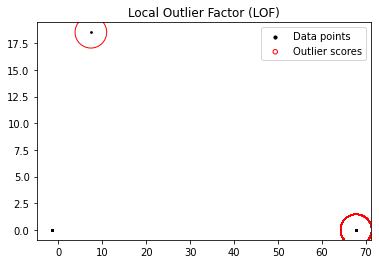

In [38]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores_pca.max() - X_scores_pca) / (X_scores_pca.max() - X_scores_pca.min())
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')

legend = plt.legend(loc='upper right')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

#### Not use following 
#### Train SOM

Here we train the Self Organizing Map on our vectorized logs and output a few vizualiztions of the trained model

In [39]:
map_size = 16
model = train(transformed_data, map_size, 0, 2)

 Training...
 random_initialization took: 0.006000 seconds
 Rough training...
 radius_ini: 6.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.142000, quantization error: 35.949628



training dataset is of size {inp.shape[0]}


 epoch: 2 ---> elapsed time:  0.170000, quantization error: 1.229027

 epoch: 3 ---> elapsed time:  0.122000, quantization error: 0.117411

 epoch: 4 ---> elapsed time:  0.118000, quantization error: 0.103476

 epoch: 5 ---> elapsed time:  0.122000, quantization error: 0.093404

 epoch: 6 ---> elapsed time:  0.114000, quantization error: 0.084052

 epoch: 7 ---> elapsed time:  0.249000, quantization error: 0.075401

 epoch: 8 ---> elapsed time:  0.123000, quantization error: 0.067429

 epoch: 9 ---> elapsed time:  0.132000, quantization error: 0.060111

 epoch: 10 ---> elapsed time:  0.132000, quantization error: 0.053420

 epoch: 11 ---> elapsed time:  0.132000, quantization error: 0.047327

 epoch: 12 ---> elapsed time:  0.122000, quantization error: 0.041802

 epoch: 13 ---> elapsed time:  0.128000, quantization error: 0.036812

 epoch: 14 ---> elapsed time:  0.124000, quantization error: 0.032324

 epoch: 15 ---> elapsed time:  0.130000, quantization error: 0.028307

 epoch: 16 ---

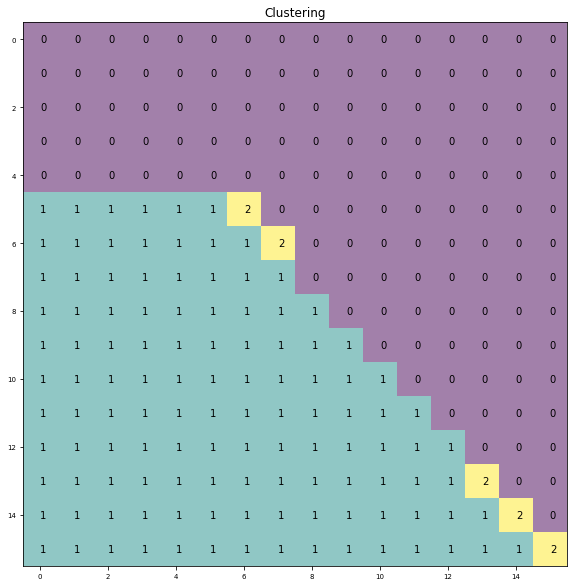

In [54]:
from sompy.visualization.hitmap import HitMapView
model.cluster(3)
hits  = HitMapView(10,10,"Clustering",text_size=7)
a = hits.show(model)

In [55]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=10)
view2D.show(model, col_sz=4, which_dim="all", denormalize=True)

TypeError: show() got an unexpected keyword argument 'denormalize'

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(10,10,"Hits Map",text_size=7)
vhts.show(model, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

In [41]:
 m = model.codebook.matrix.reshape([16, 16, transformed_data.shape[1]])

#### Measure Distances

We want to generate some baseline summary statistics of our model

In [42]:
#then = time.
distances = get_anomaly_score(transformed_data, 8, m)

print(max(distances))
print(min(distances))
print(np.mean(distances))
print(np.std(distances))

0.18450720011209432
0.17082959971514644
0.1722224929971604
0.00181233380169263


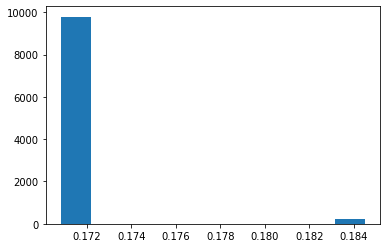

In [43]:
plt.hist(distances)
plt.show()

In [44]:
threshold = 3*np.std(distances) + np.mean(distances)
threshold

0.17765949440223827

In [45]:
threshold

0.17765949440223827

In [46]:
count = 0
for i, j in enumerate(distances):
    if j > threshold:
        print(j, data.loc[i])
        count += 1
print(count)

0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6722, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6723, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6724, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6725, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6726, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6727, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6728, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6729, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6730, dtype: object
0.18450720011209432 message    Thread

0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 8210, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 8211, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 8212, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 8213, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 8214, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 8215, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 8216, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 8217, dtype: object
0.18450720011209432 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 8218, dtype: object
0.18450720011209432 message    Thread

In [47]:
data.message.value_counts()

DEBUGProcessedoutofpackages                            9786
ThreadodcsserverINFOComposetypestatedoneComposedone     213
rootCMDusrlocalbinmonitorapachestatsshdevnull             1
Name: message, dtype: int64

#### Test 

In [48]:
infer(w2vmodel,m,'rootCMDusrlocalbinmonitorapachestatsshdevnull', data,threshold)

(0, [0.17082958158177497])

In [49]:
infer(w2vmodel,m,'DEBUGProcessedoutofpackages', data,threshold)

(0, [0.17195527992515147])

In [50]:
infer(w2vmodel,m,'ThreadodcsserverINFOComposetypestatedoneComposedone ', data,threshold)

(1, [0.18450721729320518])

In [51]:
infer(w2vmodel,m,'FSKSDNKSDNKSfdhfhfdhfdhfdhfdhfd  hfhf dlksfljscomLDN', data,threshold)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 4 word types from a corpus of 10001 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 4 unique words (100% of original 4, drops 0)
effective_min_count=1 leaves 10001 word corpus (100% of original 10001, drops 0)
deleting the raw counts dictionary of 4 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 380 word corpus (3.8% of prior 10001)
estimated required memory for 4 words and 100 dimensions: 5200 bytes
resetting layer weights
training model with 1 workers on 4 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10001 raw words (381 effective words) took 0.0s, 102392 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 10001 raw words (400 effective words) 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 49 : training on 10001 raw words (386 effective words) took 0.0s, 43974 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 50 : training on 10001 raw words (416 effective words) took 0.0s, 100338 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 51 : training on 10001 raw words (397 effective words) took 0.0s, 51158 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 52 : training on 10001 raw words (396 effective words) took 0.0s, 88969 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 53 : training on 10001 raw words (408 effective words) took 0.0s, 91853 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 54 : training on 10001 raw words (395 effective words) took 0.0s, 70623 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH

EPOCH - 101 : training on 10001 raw words (384 effective words) took 0.0s, 27199 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 102 : training on 10001 raw words (388 effective words) took 0.0s, 125843 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 103 : training on 10001 raw words (391 effective words) took 0.0s, 83078 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 104 : training on 10001 raw words (391 effective words) took 0.0s, 93376 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 105 : training on 10001 raw words (368 effective words) took 0.0s, 49716 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 106 : training on 10001 raw words (395 effective words) took 0.0s, 155988 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 107 : training on 10001 raw words (398 effective

worker thread finished; awaiting finish of 0 more threads
EPOCH - 154 : training on 10001 raw words (361 effective words) took 0.0s, 90578 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 155 : training on 10001 raw words (358 effective words) took 0.0s, 140451 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 156 : training on 10001 raw words (369 effective words) took 0.0s, 183884 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 157 : training on 10001 raw words (394 effective words) took 0.0s, 87933 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 158 : training on 10001 raw words (367 effective words) took 0.0s, 89140 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 159 : training on 10001 raw words (347 effective words) took 0.0s, 26282 effective words/s
worker thread finished; awaiting finish of 0 more thread

worker thread finished; awaiting finish of 0 more threads
EPOCH - 206 : training on 10001 raw words (386 effective words) took 0.0s, 99967 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 207 : training on 10001 raw words (361 effective words) took 0.0s, 106186 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 208 : training on 10001 raw words (361 effective words) took 0.0s, 89308 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 209 : training on 10001 raw words (364 effective words) took 0.0s, 166563 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 210 : training on 10001 raw words (347 effective words) took 0.0s, 246156 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 211 : training on 10001 raw words (381 effective words) took 0.0s, 156090 effective words/s
worker thread finished; awaiting finish of 0 more thre

EPOCH - 258 : training on 10001 raw words (378 effective words) took 0.0s, 86671 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10001 raw words (355 effective words) took 0.0s, 134973 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10001 raw words (386 effective words) took 0.0s, 357149 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10001 raw words (379 effective words) took 0.0s, 55186 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10001 raw words (352 effective words) took 0.0s, 104400 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 263 : training on 10001 raw words (352 effective words) took 0.0s, 88026 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 264 : training on 10001 raw words (422 effectiv

worker thread finished; awaiting finish of 0 more threads
EPOCH - 311 : training on 10001 raw words (392 effective words) took 0.0s, 223737 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 312 : training on 10001 raw words (397 effective words) took 0.0s, 357109 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 313 : training on 10001 raw words (362 effective words) took 0.0s, 52049 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 314 : training on 10001 raw words (382 effective words) took 0.0s, 442721 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 315 : training on 10001 raw words (418 effective words) took 0.0s, 108891 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 316 : training on 10001 raw words (378 effective words) took 0.0s, 116710 effective words/s
worker thread finished; awaiting finish of 0 more thr

EPOCH - 363 : training on 10001 raw words (386 effective words) took 0.0s, 44575 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 364 : training on 10001 raw words (381 effective words) took 0.0s, 53608 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 365 : training on 10001 raw words (374 effective words) took 0.0s, 142616 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 366 : training on 10001 raw words (409 effective words) took 0.0s, 72481 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 367 : training on 10001 raw words (357 effective words) took 0.0s, 80735 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 368 : training on 10001 raw words (372 effective words) took 0.0s, 47230 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 369 : training on 10001 raw words (424 effective 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 416 : training on 10001 raw words (400 effective words) took 0.0s, 174165 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 417 : training on 10001 raw words (371 effective words) took 0.0s, 82245 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 418 : training on 10001 raw words (373 effective words) took 0.0s, 74455 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 419 : training on 10001 raw words (389 effective words) took 0.0s, 77186 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 420 : training on 10001 raw words (406 effective words) took 0.0s, 473448 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 421 : training on 10001 raw words (375 effective words) took 0.0s, 111320 effective words/s
worker thread finished; awaiting finish of 0 more threa

EPOCH - 468 : training on 10001 raw words (335 effective words) took 0.0s, 85739 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 469 : training on 10001 raw words (373 effective words) took 0.0s, 131335 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 470 : training on 10001 raw words (364 effective words) took 0.0s, 195098 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 471 : training on 10001 raw words (398 effective words) took 0.0s, 104074 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 472 : training on 10001 raw words (386 effective words) took 0.0s, 56791 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 473 : training on 10001 raw words (372 effective words) took 0.0s, 116683 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 474 : training on 10001 raw words (355 effecti

worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10001 raw words (402 effective words) took 0.0s, 303057 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10001 raw words (396 effective words) took 0.0s, 79990 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10001 raw words (361 effective words) took 0.0s, 385703 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 524 : training on 10001 raw words (388 effective words) took 0.0s, 63043 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 525 : training on 10001 raw words (364 effective words) took 0.0s, 119700 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 526 : training on 10001 raw words (378 effective words) took 0.0s, 56057 effective words/s
worker thread finished; awaiting finish of 0 more threa

(1, [0.34763240684389884])

In [52]:
infer(w2vmodel,m,'this is not a log message',data,threshold)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 4 word types from a corpus of 10001 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 4 unique words (100% of original 4, drops 0)
effective_min_count=1 leaves 10001 word corpus (100% of original 10001, drops 0)
deleting the raw counts dictionary of 4 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 380 word corpus (3.8% of prior 10001)
estimated required memory for 4 words and 100 dimensions: 5200 bytes
resetting layer weights
training model with 1 workers on 4 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10001 raw words (381 effective words) took 0.0s, 359172 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 10001 raw words (400 effective words) 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 49 : training on 10001 raw words (386 effective words) took 0.0s, 87955 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 50 : training on 10001 raw words (416 effective words) took 0.0s, 91656 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 51 : training on 10001 raw words (397 effective words) took 0.0s, 588059 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 52 : training on 10001 raw words (396 effective words) took 0.0s, 51942 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 53 : training on 10001 raw words (408 effective words) took 0.0s, 34713 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 54 : training on 10001 raw words (395 effective words) took 0.0s, 83470 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH

EPOCH - 101 : training on 10001 raw words (384 effective words) took 0.0s, 111104 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 102 : training on 10001 raw words (388 effective words) took 0.0s, 74710 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 103 : training on 10001 raw words (391 effective words) took 0.0s, 303975 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 104 : training on 10001 raw words (391 effective words) took 0.0s, 120471 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 105 : training on 10001 raw words (368 effective words) took 0.0s, 348955 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 106 : training on 10001 raw words (395 effective words) took 0.0s, 164421 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 107 : training on 10001 raw words (398 effect

EPOCH - 153 : training on 10001 raw words (361 effective words) took 0.0s, 249843 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 154 : training on 10001 raw words (361 effective words) took 0.0s, 249432 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 155 : training on 10001 raw words (358 effective words) took 0.0s, 127395 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 156 : training on 10001 raw words (369 effective words) took 0.0s, 130149 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 157 : training on 10001 raw words (394 effective words) took 0.0s, 206984 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 158 : training on 10001 raw words (367 effective words) took 0.0s, 57742 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 159 : training on 10001 raw words (347 effect

worker thread finished; awaiting finish of 0 more threads
EPOCH - 206 : training on 10001 raw words (386 effective words) took 0.0s, 109312 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 207 : training on 10001 raw words (361 effective words) took 0.0s, 120219 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 208 : training on 10001 raw words (361 effective words) took 0.0s, 40775 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 209 : training on 10001 raw words (364 effective words) took 0.0s, 147265 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 210 : training on 10001 raw words (347 effective words) took 0.0s, 320649 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 211 : training on 10001 raw words (381 effective words) took 0.0s, 195949 effective words/s
worker thread finished; awaiting finish of 0 more thr

EPOCH - 258 : training on 10001 raw words (378 effective words) took 0.0s, 242423 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10001 raw words (355 effective words) took 0.0s, 42454 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10001 raw words (386 effective words) took 0.0s, 89600 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10001 raw words (379 effective words) took 0.0s, 63093 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10001 raw words (352 effective words) took 0.0s, 255248 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 263 : training on 10001 raw words (352 effective words) took 0.0s, 78810 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 264 : training on 10001 raw words (422 effective

worker thread finished; awaiting finish of 0 more threads
EPOCH - 311 : training on 10001 raw words (392 effective words) took 0.0s, 63123 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 312 : training on 10001 raw words (397 effective words) took 0.0s, 141521 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 313 : training on 10001 raw words (362 effective words) took 0.0s, 45018 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 314 : training on 10001 raw words (382 effective words) took 0.0s, 90010 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 315 : training on 10001 raw words (418 effective words) took 0.0s, 213870 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 316 : training on 10001 raw words (378 effective words) took 0.0s, 72278 effective words/s
worker thread finished; awaiting finish of 0 more thread

EPOCH - 363 : training on 10001 raw words (386 effective words) took 0.0s, 68297 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 364 : training on 10001 raw words (381 effective words) took 0.0s, 73743 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 365 : training on 10001 raw words (374 effective words) took 0.0s, 67515 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 366 : training on 10001 raw words (409 effective words) took 0.0s, 244591 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 367 : training on 10001 raw words (357 effective words) took 0.0s, 87642 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 368 : training on 10001 raw words (372 effective words) took 0.0s, 62460 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 369 : training on 10001 raw words (424 effective 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 416 : training on 10001 raw words (400 effective words) took 0.0s, 46943 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 417 : training on 10001 raw words (371 effective words) took 0.0s, 136130 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 418 : training on 10001 raw words (373 effective words) took 0.0s, 139304 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 419 : training on 10001 raw words (389 effective words) took 0.0s, 62259 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 420 : training on 10001 raw words (406 effective words) took 0.0s, 304555 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 421 : training on 10001 raw words (375 effective words) took 0.0s, 46336 effective words/s
worker thread finished; awaiting finish of 0 more threa

EPOCH - 468 : training on 10001 raw words (335 effective words) took 0.0s, 38925 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 469 : training on 10001 raw words (373 effective words) took 0.0s, 80457 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 470 : training on 10001 raw words (364 effective words) took 0.0s, 40716 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 471 : training on 10001 raw words (398 effective words) took 0.0s, 76564 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 472 : training on 10001 raw words (386 effective words) took 0.0s, 239582 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 473 : training on 10001 raw words (372 effective words) took 0.0s, 72001 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 474 : training on 10001 raw words (355 effective 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10001 raw words (402 effective words) took 0.0s, 191261 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10001 raw words (396 effective words) took 0.0s, 54837 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10001 raw words (361 effective words) took 0.0s, 102049 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 524 : training on 10001 raw words (388 effective words) took 0.0s, 177407 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 525 : training on 10001 raw words (364 effective words) took 0.0s, 288476 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 526 : training on 10001 raw words (378 effective words) took 0.0s, 79250 effective words/s
worker thread finished; awaiting finish of 0 more thre

(1, [0.3437718897075974])

In [53]:
infer(w2vmodel,m,'message',data,threshold)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 4 word types from a corpus of 10001 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 4 unique words (100% of original 4, drops 0)
effective_min_count=1 leaves 10001 word corpus (100% of original 10001, drops 0)
deleting the raw counts dictionary of 4 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 380 word corpus (3.8% of prior 10001)
estimated required memory for 4 words and 100 dimensions: 5200 bytes
resetting layer weights
training model with 1 workers on 4 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10001 raw words (381 effective words) took 0.0s, 99441 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 10001 raw words (400 effective words) t

worker thread finished; awaiting finish of 0 more threads
EPOCH - 49 : training on 10001 raw words (386 effective words) took 0.0s, 42234 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 50 : training on 10001 raw words (416 effective words) took 0.0s, 70714 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 51 : training on 10001 raw words (397 effective words) took 0.0s, 77445 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 52 : training on 10001 raw words (396 effective words) took 0.0s, 60277 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 53 : training on 10001 raw words (408 effective words) took 0.0s, 70146 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 54 : training on 10001 raw words (395 effective words) took 0.0s, 55884 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 102 : training on 10001 raw words (388 effective words) took 0.0s, 256266 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 103 : training on 10001 raw words (391 effective words) took 0.0s, 92905 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 104 : training on 10001 raw words (391 effective words) took 0.0s, 41643 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 105 : training on 10001 raw words (368 effective words) took 0.0s, 181923 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 106 : training on 10001 raw words (395 effective words) took 0.0s, 79401 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 107 : training on 10001 raw words (398 effective words) took 0.0s, 98849 effective words/s
worker thread finished; awaiting finish of 0 more thread

EPOCH - 154 : training on 10001 raw words (361 effective words) took 0.0s, 86597 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 155 : training on 10001 raw words (358 effective words) took 0.0s, 78777 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 156 : training on 10001 raw words (369 effective words) took 0.0s, 45654 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 157 : training on 10001 raw words (394 effective words) took 0.0s, 127997 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 158 : training on 10001 raw words (367 effective words) took 0.0s, 75229 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 159 : training on 10001 raw words (347 effective words) took 0.0s, 53371 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 160 : training on 10001 raw words (390 effective 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 207 : training on 10001 raw words (361 effective words) took 0.0s, 82674 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 208 : training on 10001 raw words (361 effective words) took 0.0s, 82297 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 209 : training on 10001 raw words (364 effective words) took 0.0s, 120558 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 210 : training on 10001 raw words (347 effective words) took 0.0s, 250785 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 211 : training on 10001 raw words (381 effective words) took 0.0s, 95111 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 212 : training on 10001 raw words (359 effective words) took 0.0s, 91950 effective words/s
worker thread finished; awaiting finish of 0 more thread

EPOCH - 259 : training on 10001 raw words (355 effective words) took 0.0s, 48595 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10001 raw words (386 effective words) took 0.0s, 155298 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10001 raw words (379 effective words) took 0.0s, 93561 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10001 raw words (352 effective words) took 0.0s, 89750 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 263 : training on 10001 raw words (352 effective words) took 0.0s, 93789 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 264 : training on 10001 raw words (422 effective words) took 0.0s, 107566 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 265 : training on 10001 raw words (403 effective

worker thread finished; awaiting finish of 0 more threads
EPOCH - 312 : training on 10001 raw words (397 effective words) took 0.0s, 176515 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 313 : training on 10001 raw words (362 effective words) took 0.0s, 58321 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 314 : training on 10001 raw words (382 effective words) took 0.0s, 52197 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 315 : training on 10001 raw words (418 effective words) took 0.0s, 435297 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 316 : training on 10001 raw words (378 effective words) took 0.0s, 98607 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 317 : training on 10001 raw words (354 effective words) took 0.0s, 121303 effective words/s
worker thread finished; awaiting finish of 0 more threa

EPOCH - 364 : training on 10001 raw words (381 effective words) took 0.0s, 49584 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 365 : training on 10001 raw words (374 effective words) took 0.0s, 122855 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 366 : training on 10001 raw words (409 effective words) took 0.0s, 70624 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 367 : training on 10001 raw words (357 effective words) took 0.0s, 241280 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 368 : training on 10001 raw words (372 effective words) took 0.0s, 45922 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 369 : training on 10001 raw words (424 effective words) took 0.0s, 254068 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 370 : training on 10001 raw words (393 effectiv

worker thread finished; awaiting finish of 0 more threads
EPOCH - 417 : training on 10001 raw words (371 effective words) took 0.0s, 59110 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 418 : training on 10001 raw words (373 effective words) took 0.0s, 72019 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 419 : training on 10001 raw words (389 effective words) took 0.0s, 92030 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 420 : training on 10001 raw words (406 effective words) took 0.0s, 71136 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 421 : training on 10001 raw words (375 effective words) took 0.0s, 65621 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 422 : training on 10001 raw words (322 effective words) took 0.0s, 41807 effective words/s
worker thread finished; awaiting finish of 0 more threads


EPOCH - 469 : training on 10001 raw words (373 effective words) took 0.0s, 150612 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 470 : training on 10001 raw words (364 effective words) took 0.0s, 37732 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 471 : training on 10001 raw words (398 effective words) took 0.0s, 65631 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 472 : training on 10001 raw words (386 effective words) took 0.0s, 57252 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 473 : training on 10001 raw words (372 effective words) took 0.0s, 151691 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 474 : training on 10001 raw words (355 effective words) took 0.0s, 96036 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 475 : training on 10001 raw words (392 effective

worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10001 raw words (396 effective words) took 0.0s, 68133 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10001 raw words (361 effective words) took 0.0s, 89103 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 524 : training on 10001 raw words (388 effective words) took 0.0s, 48360 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 525 : training on 10001 raw words (364 effective words) took 0.0s, 149251 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 526 : training on 10001 raw words (378 effective words) took 0.0s, 127880 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 527 : training on 10001 raw words (360 effective words) took 0.0s, 73512 effective words/s
worker thread finished; awaiting finish of 0 more thread

(1, [0.3502651230292787])